**First, we import the necessary libraries as follows:**

In [0]:
import numpy as np
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

**Let's set up the Pong environment and plot a frame:**

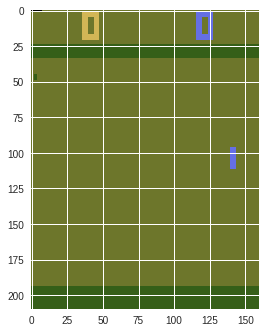

In [2]:
env = gym.make("Pong-v0") # environment info
observation = env.reset()

for i in range(22):
  # The ball is released after 20 frames
  if i > 20:
    plt.imshow(observation)
    plt.show()
    
  # Get the next observation
  observtion, _, _, _ = env.step(1)
  
  ## Frame of the Pong game by OpenAI

**Before we implement the algorithm, we need a function that preprocesses the input data:**

In [0]:
def preprocess_frame(frame):
  
  # remove top part of frame and some background
  frame = frame[35:195, 10:150]
  
  # grayscale frame and downsize by factor 2
  frame = frame[::2, ::2, 0]
  
  # set background to 0
  frame[frame == 144] = 0
  frame[frame == 109] = 0
  
  # set ball and paddles to 1
  frame[frame != 0] = 1
  return frame.astype(np.float).ravel()

**Let's see what the preprocessed data looks like:**

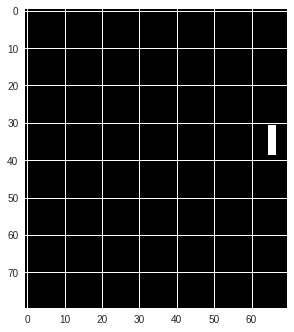

In [4]:
obs_preprocessed = preprocess_frame(observation).reshape(80, 70)

plt.imshow(obs_preprocessed, cmap = 'gray')
plt.show()

## Preprocessed frame of Pong (reshaped to 2D)

**To extract temporal information from the game, we use the difference between 2 successive frames:**

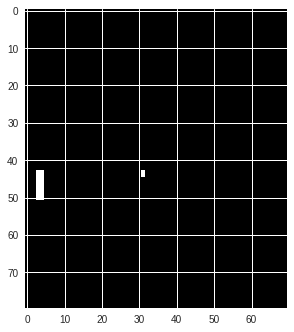

In [5]:
observation_next, _, _, _ = env.step(1)

diff = preprocess_frame(observation_next) - preprocess_frame(observation)

plt.imshow(diff.reshape(80, 70), cmap = 'gray')
plt.show()

## Difference between 2 successive frames of Pong (reshaped to 2D)

**Now we can start implementing our three-layer model. Let's start by defining the weights:**

In [6]:
input_dim = 80 * 70
hidden_L1 = 400
hidden_L2 = 200
actions = [1, 2, 3]
n_actions = len(actions)

model = {}

with tf.variable_scope('L1', reuse = False):
  init_W1 = tf.truncated_normal_initializer(mean = 0, 
                                            stddev = 1. / np.sqrt(input_dim), 
                                            dtype = tf.float32)
  model['W1'] = tf.get_variable("W1", [input_dim, hidden_L1],
                                initializer = init_W1)
  
with tf.variable_scope('L2', reuse = False):
  init_W2 = tf.truncated_normal_initializer(mean = 0,
                                            stddev = 1. / np.sqrt(hidden_L1),
                                            dtype = tf.float32)
  model['W2'] = tf.get_variable("W2", [hidden_L1, n_actions],
                                initializer = init_W2)

Instructions for updating:
Colocations handled automatically by placer.


**Next, we define the functions for our policies:**

In [0]:
def policy_forward(x):
  x = tf.matmul(x, model['W1'])
  x = tf.nn.relu(x)
  x = tf.matmul(x, model['W2'])
  p = tf.nn.softmax(x)
  return p

**For our algorithm, we need to define a function for the discounted reward:**

In [0]:
def discounted_rewards(reward, gamma):
  discounted_function = lambda a, v: a * gamma + v
  reward_reverse = tf.scan(discounted_function, tf.reverse(reward, [True, False]))
  discounted_reward = tf.reverse(reward_reverse, [True, False])
  return discounted_reward

**Before proceeding, we need to define the hyperparameters:**

In [0]:
learning_rate = 0.001
decay_rate = 0.99
gamma = 0.99
batch_size = 10

**We have to set our backwards update separately by defining placeholders:**

In [0]:
# TensorFlow placeholders
episode_x = tf.placeholder(dtype = tf.float32,
                           shape = [None, input_dim])
episode_y = tf.placeholder(dtype = tf.float32,
                           shape = [None, n_actions])
episode_reward = tf.placeholder(dtype = tf.float32,
                                shape = [None, 1])

episode_discounted_reward = discounted_rewards(episode_reward, gamma)
episode_mean, episode_variance = tf.nn.moments(episode_discounted_reward, [0], shift = None)

# Normalize discounted reward
episode_discounted_reward -= episode_mean
episode_discounted_reward /= tf.sqrt(episode_variance + 1e-6)

# Optimizer settings
tf_aprob = policy_forward(episode_x)
loss = tf.nn.l2_loss(episode_y - tf_aprob)
optimizer = tf.train.AdamOptimizer(learning_rate)
gradients = optimizer.compute_gradients(loss, 
                                        var_list = tf.trainable_variables(),
                                        grad_loss = episode_discounted_reward)
train_op = optimizer.apply_gradients(gradients)

# Initialize graph
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

# Settings to save the trained model
saver = tf.train.Saver(tf.global_variables())
save_path = 'pong_r1.ckpt'

**Now, we can initialize the values and run our algorithm:**

In [16]:
obs_prev = None
xs, ys, rs, = [], [], []
reward_sum = 0
episode_number = 0
reward_window = None
reward_best = -22
history = []

observation = env.reset()

while True:
  # if True: # uncomment this line if you want to see the agent play while training
  #   env.render() 
    
  # Preprocess the observation, set input to network to be difference image
  obs_cur = preprocess_frame(observation)
  obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
  obs_prev = obs_cur
    
  # Sample an action (policy)
  feed = {episode_x: np.reshape(obs_diff, (1,-1))}
  aprob = sess.run(tf_aprob, feed)
  aprob = aprob[0, :]
  action = np.random.choice(n_actions, p = aprob)
  label = np.zeros_like(aprob)
  label[action] = 1
    
  # Return action to environment and extract next observation, reward and status
  observation, reward, done, info = env.step(action + 1)
  reward_sum += reward
    
  # Record game history
  xs.append(obs_diff)
  ys.append(label)
  rs.append(reward)
    
  if done:
    history.append(reward_sum)
    reward_window = -21 if reward_window is None else np.mean(history[-100:])
      
    # Update the weights with the stored values (update policies)
    feed = {episode_x: np.vstack(xs),
            episode_y: np.vstack(ys),
            episode_reward: np.vstack(rs), }
    _ = sess.run(train_op, feed)
      
    print('episode {:2d}: reward: {:2.0f}'.format(episode_number, reward_sum))
      
    xs, ys, rs = [], [], []
    episode_number += 1
    observation = env.reset()
    reward_sum = 0
      
    # Save best model after every 10 episodes
    if (episode_number % 10 == 0) & (reward_window > reward_best):
      saver.save(sess, save_path, global_step = episode_number)
      reward_best = reward_window
      print("Save best model {:2d}: {:2.5f} (reward window)".format(episode_number, reward_window))

episode  0: reward: -21
episode  1: reward: -21
episode  2: reward: -21
episode  3: reward: -20
episode  4: reward: -20
episode  5: reward: -18
episode  6: reward: -19
episode  7: reward: -21
episode  8: reward: -21
episode  9: reward: -19
Save best model 10: -20.10000 (reward window)
episode 10: reward: -21
episode 11: reward: -19
episode 12: reward: -21
episode 13: reward: -20
episode 14: reward: -19
episode 15: reward: -21
episode 16: reward: -19
episode 17: reward: -21
episode 18: reward: -21
episode 19: reward: -20
episode 20: reward: -20
episode 21: reward: -20
episode 22: reward: -19
episode 23: reward: -20
episode 24: reward: -21
episode 25: reward: -20
episode 26: reward: -20
episode 27: reward: -21
episode 28: reward: -21
episode 29: reward: -20
episode 30: reward: -21
episode 31: reward: -20
episode 32: reward: -21
episode 33: reward: -21
episode 34: reward: -19
episode 35: reward: -19
episode 36: reward: -20
episode 37: reward: -21
episode 38: reward: -19
episode 39: reward

KeyboardInterrupt: ignored

**When our algorithm reaches about 2000 episodes, we can stop training and plot the results:**

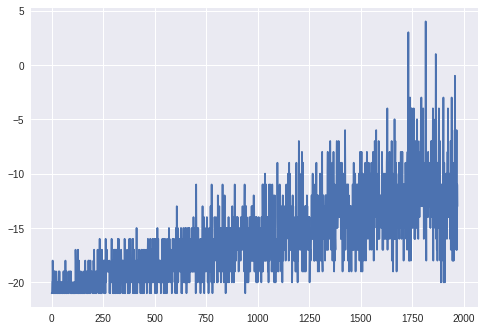

In [19]:
plt.plot(history)
plt.show()

# The scores against the number of trained episodes

**Finally, we want to see how our final model performs in OpenAI's Gym:**

In [0]:
# env = gym.make("Pong-v0")
# tf_x = tf.placeholder(dtype = tf.float32, shape = [None, input_dim])

# observation = env.reset()

# while True:
#   # if True: env.render()
  
#   # Preprocess the observation, set input to network to be difference image
#   obs_cur = preprocess_frame(observation)
#   obs_diff = obs_cur - obs_prev if obs_prev is not None else np.zeros(input_dim)
#   obs_prev = obs_cur
  
#   # Sample an action (policy)
#   feed = {tf_x: np.reshape(obs_diff, (1, -1))}
#   aprob = sess.run(tf_aprob, feed)
#   aprob = aprob[0, :]
#   action = np.random.choice(n_actions, p = aprob)
#   label = np.zeros_like(aprob)
#   label[action] = 1
  
#   # Return action to environment and extract next observation, reward and status
#   observation, reward, done, info = env.step(action + 1)
  
#   if done: observation = env.reset()